In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Import Data Files

In [2]:
game_goals = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-03/game_goals.csv')

In [3]:
to_drop = ['rank','date','team','at','opp','location','assists_even','assists_powerplay','assists_short']
game_goals.drop(to_drop, axis=1, inplace=True)
game_goals['shot_percent'] = game_goals['shot_percent'].fillna(0.0)

In [4]:
league_data = pd.read_csv("C:/Users/john.sutton/Documents/__DSBA/Visual Analytics/Final_Project/league_data.csv")

In [5]:
league_data['season'] = league_data['Season'].apply(lambda x: x[:4]).astype('int')
league_data = league_data[['season','G']].rename(columns={'G': 'league_avg_gpg'})

---
## Add Columns to Dataset

In [6]:
# Column to aggregate number of games played
game_goals['game_count'] = 1

# Binary column for wins and losses
game_goals['wins'] = game_goals['outcome'].apply(lambda x: 1 if x == 'W' else 0)

#### Add Player's Goals and Assists per game by season to dataset

In [7]:
# Aggregate player's Goals and Assists by season
player_seasons = game_goals[['player','season','goals','assists','game_count']].groupby(['player','season'], as_index=False).sum()

# Calculate player's GoalsPerGame and AssistsPerGame by season
player_seasons['season_gpg'] = player_seasons['goals'] / player_seasons['game_count']
player_seasons['season_apg'] = player_seasons['assists'] / player_seasons['game_count']

# Add player's season GPG and APG to game_goals dataframe
game_goals = game_goals.merge(player_seasons[['player','season','season_gpg','season_apg']], how='left', on=['player','season'])

# Add the league average goals per game by season
game_goals = game_goals.merge(league_data, how='left', on='season')

---
# Add in games to 82 with Hypothetical goals/assists/points

In [82]:
hypothetical_goal_data = game_goals.copy()

In [83]:
# Mark the last game in a player's season
hypothetical_goal_data['season_end'] = np.where(hypothetical_goal_data['season'].shift(-1) == hypothetical_goal_data['season'], 0, 1)

# Add column for binary hypothetical rows
hypothetical_goal_data['hypothetical'] = 0

In [84]:
hypothetical_goal_data['age_years'] = hypothetical_goal_data['age'].str[:2].astype(int)
hypothetical_goal_data['age_remainder'] = hypothetical_goal_data['age'].str[-3:].astype(int)
hypothetical_goal_data['age_days'] = (hypothetical_goal_data['age_years'] * 365) + hypothetical_goal_data['age_remainder']
hypothetical_goal_data = hypothetical_goal_data.drop(['age_remainder','age'], axis=1)

In [85]:
%%time
for index, row in hypothetical_goal_data.iterrows():   
    if (row['season_end'] == 1) & (row['game_num'] < 82):
        next_game = int(row['game_num']) + 1
        for i in range(next_game, 83):
            new_row = {'player':row['player'], 'season':int(row['season']), 'game_num': i, 
                       'goals': row['season_gpg'], 'assists': row['season_apg'], 'hypothetical': 1,
                       'points': row['season_gpg'] + row['season_apg'], 'game_count': 1, 'age_days': row['age_days'] + 1}
            hypothetical_goal_data = hypothetical_goal_data.append([new_row])

hypothetical_goal_data = hypothetical_goal_data.sort_values(['player','season','game_num'])

Wall time: 2min 57s


In [86]:
# Drop erroneous columns
hypothetical_goal_data = hypothetical_goal_data[['player','season','game_num','goals','assists','points','season_gpg',
                                                 'season_apg','league_avg_gpg','hypothetical','game_count','age_days']]
# Reset index
hypothetical_goal_data.reset_index(drop=True, inplace=True)

---

### Modify original Game_Goals Dataset to show cumulative count of goals by player

In [87]:
# Groupby to get cumulative goals by game
cum_goals = game_goals.groupby(['player','season','game_num']).sum().groupby('player').cumsum().reset_index()
cum_goals = cum_goals.drop('shot_percent', axis=1)
cum_goals = cum_goals.add_prefix('cum_')

In [88]:
# Merge with original game_goals dataset for per game stats
goal_data = game_goals.merge(cum_goals, how='left', left_index=True, right_index=True)
goal_data = goal_data.drop(['outcome','cum_player','cum_season','cum_game_num'], axis=1)

In [89]:
# Add age in years and days
goal_data['age_years'] = goal_data['age'].str[:2].astype(int)
goal_data['age_remainder'] = goal_data['age'].str[-3:].astype(int)
goal_data['age_days'] = (goal_data['age_years'] * 365) + goal_data['age_remainder']
goal_data = goal_data.drop(['age_remainder','age'], axis=1)

# Add goals, assists, and points per game, and career shooting %
goal_data['gpg'] = goal_data['cum_goals'] / goal_data['cum_game_count']
goal_data['apg'] = goal_data['cum_assists'] / goal_data['cum_game_count']
goal_data['ppg'] = goal_data['cum_points'] / goal_data['cum_game_count']
goal_data['career_shot_percent'] = (goal_data['cum_goals'] / goal_data['cum_shots']) * 100

# Drop erroneous columns
goal_data.drop(['cum_season_gpg','cum_season_apg','cum_league_avg_gpg'], axis=1, inplace=True)

In [90]:
# Create test list of select players
players = ['Wayne Gretzky','Mario Lemieux','Sidney Crosby','Alex Ovechkin','Evgeni Malkin','Jaromir Jagr']
test = goal_data[goal_data.player.isin(players)]

### Modify original Hypothetical_Game_Goals Dataset to show cumulative count of goals by player

In [91]:
# Groupby to get cumulative goals by game
hyp_cum_goals = hypothetical_goal_data.groupby(['player','season','game_num']).sum().groupby('player').cumsum().reset_index()
hyp_cum_goals = hyp_cum_goals.add_prefix('cum_')

In [92]:
# Merge with original game_goals dataset for per game stats
hypothetical_goal_data = hypothetical_goal_data.merge(hyp_cum_goals, how='left', left_index=True, right_index=True)
hypothetical_goal_data = hypothetical_goal_data.drop(['cum_player','cum_season','cum_game_num'], axis=1)

In [93]:
# Add goals, assists, and points per game
hypothetical_goal_data['gpg'] = hypothetical_goal_data['cum_goals'] / hypothetical_goal_data['cum_game_count']
hypothetical_goal_data['apg'] = hypothetical_goal_data['cum_assists'] / hypothetical_goal_data['cum_game_count']
hypothetical_goal_data['ppg'] = hypothetical_goal_data['cum_points'] / hypothetical_goal_data['cum_game_count']

# Drop erroneous columns
hypothetical_goal_data = hypothetical_goal_data[['player','season','game_num','goals','assists','points','hypothetical',
                                                 'cum_goals','cum_assists','cum_points','cum_game_count','gpg','apg','ppg',
                                                 'age_days']]

In [94]:
# Create test list of select players
players = ['Wayne Gretzky','Mario Lemieux','Sidney Crosby','Alex Ovechkin','Evgeni Malkin','Jaromir Jagr']
hyp_test = hypothetical_goal_data[hypothetical_goal_data.player.isin(players)]

In [95]:
# Make cumulative goals, assists, and points integers
for each in ['cum_goals','cum_assists','cum_points']:
    hypothetical_goal_data[each] = hypothetical_goal_data[each].astype(int)

---
## Exploratory Data Analysis

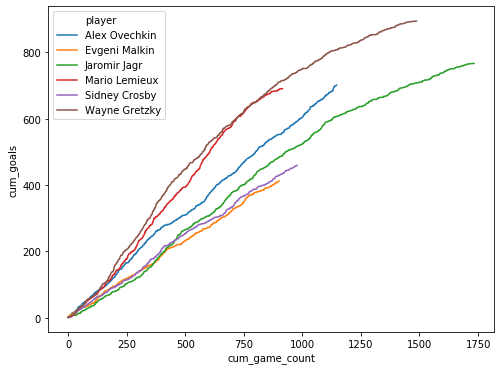

In [66]:
##### Cumulative Goals by count of games played #####

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot('cum_game_count', 'cum_goals', hue='player', data=test)

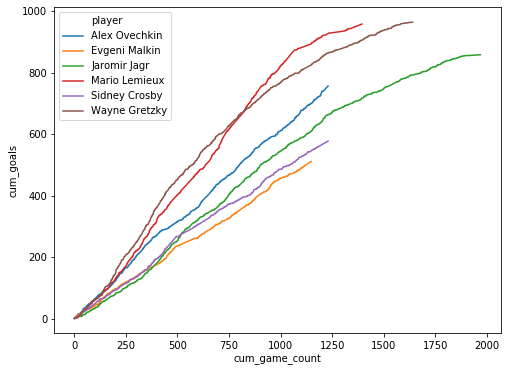

In [67]:
##### Cumulative Goals by count of games played #####

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot('cum_game_count', 'cum_goals', hue='player', data=hyp_test)

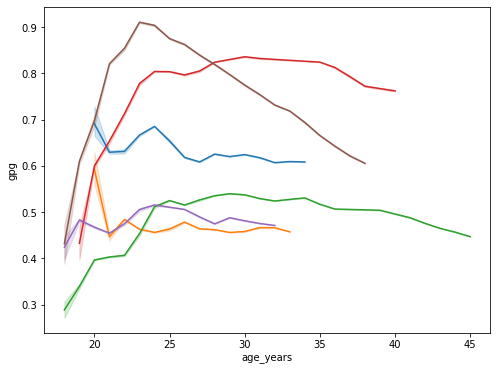

In [68]:
##### Goals-per-game by age in years #####

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot('age_years', 'gpg', hue='player', data=test, legend=False)

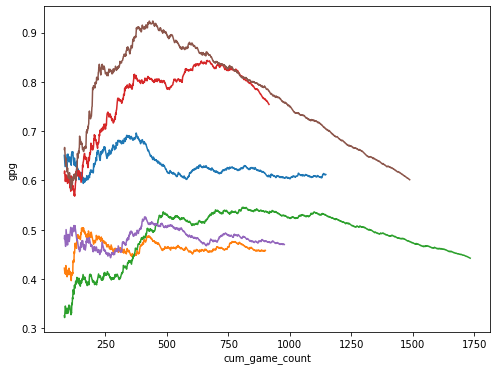

In [69]:
##### Goals-per-game by cumulative game count #####

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot('cum_game_count', 'gpg', hue='player', data=test[test['cum_game_count'] > 82], legend=False)

---

# Fun Plots

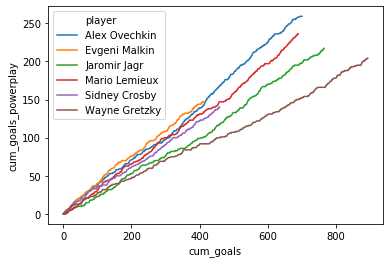

In [70]:
# PP Goals vs all goals #### Add 1:1 line ###
sns.lineplot('cum_goals', 'cum_goals_powerplay', hue='player', data=test)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

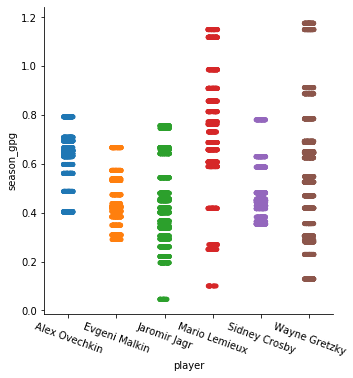

In [71]:
# GPG over career by player???
sns.catplot('player', 'season_gpg', data=test)
plt.xticks(rotation=-20)

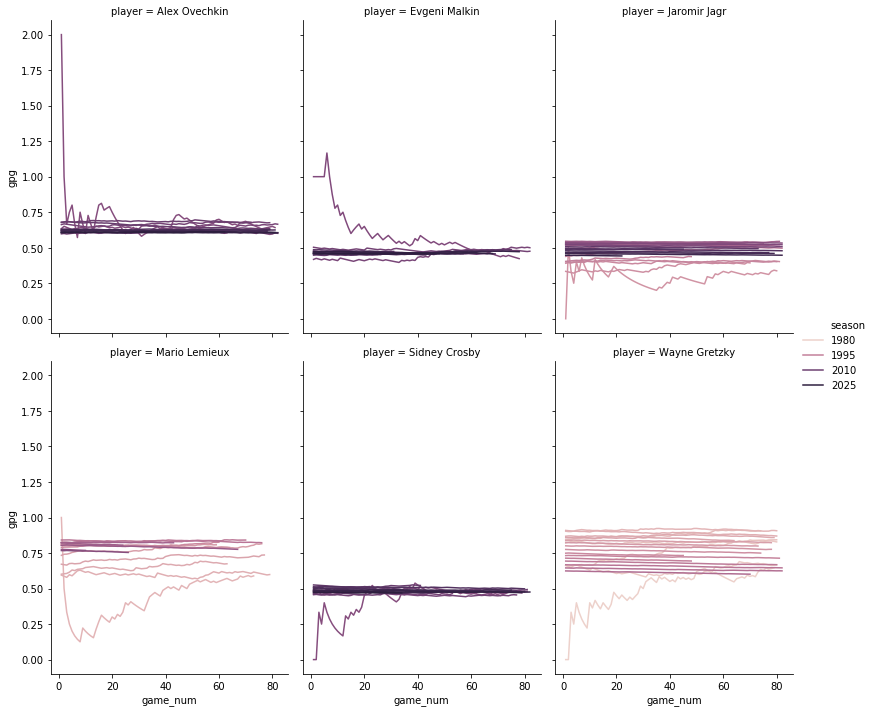

In [72]:
### GPG by season for players

sns.relplot('game_num', 'gpg', hue='season', col='player', facet_kws=dict(sharex=True), kind='line', data=test,
           height=5, aspect=.75, col_wrap=3)

(2.5, 4.1)

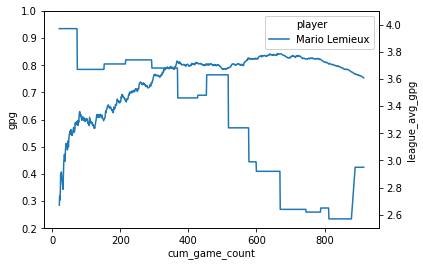

In [73]:
# Comparing GPG vs NHL goals scored per game by season - Lemieux

sns.lineplot('cum_game_count', 'gpg', hue='player', data=test[(test.cum_game_count > 20) & (test.player == 'Mario Lemieux')])
plt.ylim(0.2, 1)
ax2 = plt.twinx()
sns.lineplot('cum_game_count','league_avg_gpg', hue='player', data=test[(test.cum_game_count > 20) & (test.player == 'Mario Lemieux')])
plt.ylim(2.5,4.1)

(2.5, 4.1)

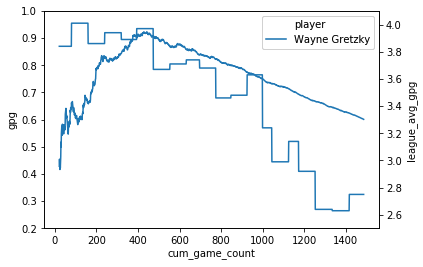

In [74]:
# Comparing GPG vs NHL goals scored per game by season - Gretzky

sns.lineplot('cum_game_count', 'gpg', hue='player', data=test[(test.cum_game_count > 20) & (test.player == 'Wayne Gretzky')])
plt.ylim(0.2,1)
ax2 = plt.twinx()
sns.lineplot('cum_game_count','league_avg_gpg', hue='player', data=test[(test.cum_game_count > 20) & (test.player == 'Wayne Gretzky')])
plt.ylim(2.5,4.1)

(2.5, 4.1)

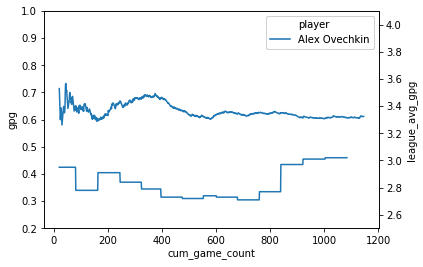

In [75]:
sns.lineplot('cum_game_count', 'gpg', hue='player', data=test[(test.cum_game_count > 20) & (test.player == 'Alex Ovechkin')])
plt.ylim(0.2,1)
ax2 = plt.twinx()
sns.lineplot('cum_game_count','league_avg_gpg', hue='player', data=test[(test.cum_game_count > 20) & (test.player == 'Alex Ovechkin')])
plt.ylim(2.5,4.1)

---
# Export Data

In [96]:
goal_data.drop('age_years', axis=1, inplace=True)

In [103]:
goal_data.to_csv('C:/Users/john.sutton/Documents/__DSBA/Visual Analytics/Final_Project/goal_data.csv', index=False)
hypothetical_goal_data.to_csv('C:/Users/john.sutton/Documents/__DSBA/Visual Analytics/Final_Project/hyp_goal_data.csv', index=False)